<a href="https://colab.research.google.com/github/shakira-anadella/dataset_ML/blob/main/UAS_ML_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


url = "https://raw.githubusercontent.com/shakira-anadella/dataset_ML/refs/heads/main/top_insta_influencers_data.csv"
df = pd.read_csv(url)

In [6]:
#Pembersihan Dataset
# Fungsi untuk mengubah shorthand (k, m, b, %) ke angka
def parse_shorthand(val):
    if isinstance(val, str):
        v = val.strip().lower()
        if v.endswith('k'):
            return float(v[:-1]) * 1_000
        elif v.endswith('m'):
            return float(v[:-1]) * 1_000_000
        elif v.endswith('b'):
            return float(v[:-1]) * 1_000_000_000
        elif v.endswith('%'):
            return float(v[:-1]) / 100
        else:
            try:
                return float(v.replace(',', ''))
            except:
                return np.nan
    return val

# Konversi kolom-kolom penting
cols_to_convert = [
    'posts', 'followers', 'avg_likes',
    'total_likes', 'new_post_avg_like', '60_day_eng_rate'
]
for col in cols_to_convert:
    df[col] = df[col].apply(parse_shorthand)

# Hilangkan baris dengan nilai kosong di kolom-kolom yang penting
important = ['influence_score'] + cols_to_convert
df_clean = df.dropna(subset=important)

# Reset index agar rapi
df_clean = df_clean.reset_index(drop=True)

# Tampilkan info dan 5 baris pertama
print("Data setelah cleaning:")
print(df_clean[important].info())
print(df_clean[important].head())

Data setelah cleaning:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   influence_score    199 non-null    int64  
 1   posts              199 non-null    float64
 2   followers          199 non-null    float64
 3   avg_likes          199 non-null    float64
 4   total_likes        199 non-null    float64
 5   new_post_avg_like  199 non-null    float64
 6   60_day_eng_rate    199 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 11.0 KB
None
   influence_score   posts    followers  avg_likes   total_likes  \
0               92  3300.0  475800000.0  8700000.0  2.900000e+10   
1               91  6900.0  366200000.0  8300000.0  5.740000e+10   
2               90   890.0  357300000.0  6800000.0  6.000000e+09   
3               93  1800.0  342700000.0  6200000.0  1.150000e+10   
4               91  6800.0  334100000.0  1900

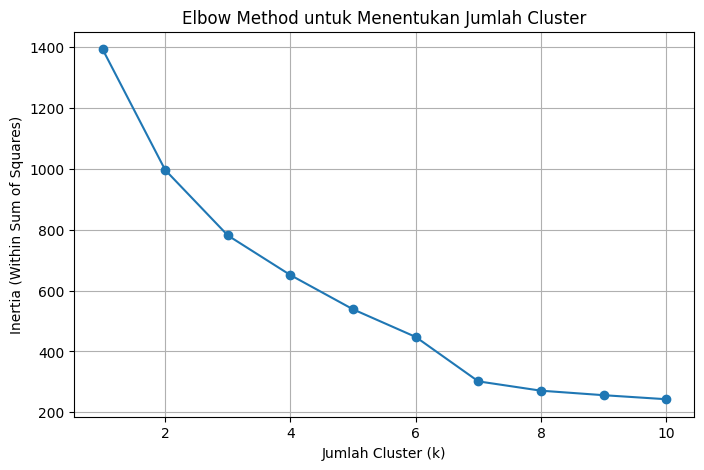

In [7]:
# Ambil fitur numerik yang sudah dibersihkan
features = ['influence_score', 'posts', 'followers', 'avg_likes',
            '60_day_eng_rate', 'new_post_avg_like', 'total_likes']
X = df_clean[features]

# Standarisasi (Z-score normalization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow Method: coba jumlah cluster 1–10
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method untuk Menentukan Jumlah Cluster')
plt.xlabel('Jumlah Cluster (k)')
plt.ylabel('Inertia (Within Sum of Squares)')
plt.grid(True)
plt.show()


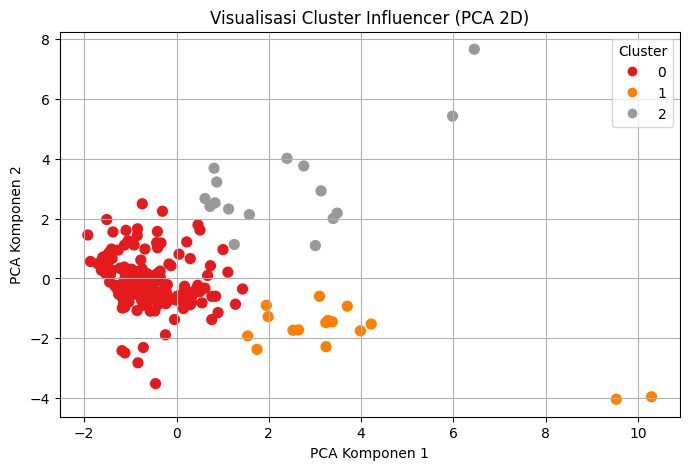

In [8]:
# Jalankan K-Means dengan k = 3
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_clean['cluster'] = kmeans.fit_predict(X_scaled)

# Lakukan PCA untuk mereduksi dimensi ke 2D (agar bisa divisualisasikan)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Visualisasi cluster
plt.figure(figsize=(8, 5))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_clean['cluster'], cmap='Set1', s=50)
plt.title("Visualisasi Cluster Influencer (PCA 2D)")
plt.xlabel("PCA Komponen 1")
plt.ylabel("PCA Komponen 2")
plt.grid(True)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


In [9]:
#Analisis Hasil CLustering

# Rata-rata nilai fitur pada masing-masing cluster
cluster_summary = df_clean.groupby('cluster')[features].mean()
print(cluster_summary)

# Contoh pengkategorian manual berdasarkan observasi
cluster_names = {
    0: "Micro Influencer",
    1: "Mid Influencer",
    2: "Mega Influencer"
}
df_clean['cluster_label'] = df_clean['cluster'].map(cluster_names)

# sebaran followers per cluster:
sns.boxplot(data=df_clean, x="cluster", y="followers")
plt.title("Sebaran Jumlah Followers per Cluster")
plt.show()

# Simpan hasil clustering ke file CSV baru
df_clean.to_csv("hasil_clustering_influencer.csv", index=False)


         influence_score        posts     followers     avg_likes  \
cluster                                                             
0              81.365269  3722.934132  6.010778e+07  1.101322e+06   
1              78.062500   767.500000  5.923750e+07  5.768750e+06   
2              90.250000  4115.625000  2.786938e+08  4.393750e+06   

         60_day_eng_rate  new_post_avg_like   total_likes  
cluster                                                    
0               0.011235       5.966126e+05  2.491772e+09  
1               0.108669       5.950000e+06  3.362281e+09  
2               0.010631       2.924512e+06  1.628125e+10  


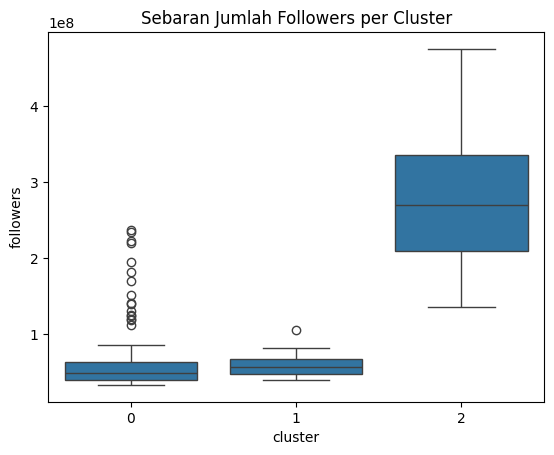

In [13]:
joblib.dump(kmeans, 'model.pkl')     # Model KMeans
joblib.dump(scaler, 'scaler.pkl')    # StandardScaler

['scaler.pkl']

In [14]:
from google.colab import files

files.download('model.pkl')
files.download('scaler.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>